In [262]:
import sys
import os

prj_path = "../../../TradingLibADS/"
sys.path.append(prj_path)

from utils.data_downloader import DataUtils
import utils.analyser as an
import utils.stock_visualizer as sv
import numpy as np

In [2]:
import datetime
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
import statsmodels
import statsmodels.api as sm
import yfinance as yf
from pandas_datareader import data as pdr
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import coint, adfuller

sys.path.insert(0, '../..')
sys.path.insert(0, '../../utils')

%load_ext autoreload
%autoreload 2
%precision %.5f
warnings.filterwarnings('ignore')

plt.style.use('qb_dark')
pio.templates.default = "darien_dark"

#### Pull in Ranked Pairs by Correlation & Co-integration for Selection


In [3]:
pairs_path = "../data/ranked_pairs_snp.csv"

pairs_df = pd.read_csv(pairs_path)
pairs_df.head(10)

,agg_rank,ticker_0,ticker_1,corr,cointeg_pval
0,0,GS,BLK,0.8344,0.0160
1,1,JPM,CRM,0.8390,0.0265
2,2,INTC,C,0.8583,0.1598
3,3,WFC,UNP,0.7002,0.0293
4,4,HON,GS,0.6692,0.0188
5,5,HON,BLK,0.8017,0.2085
6,6,JPM,GS,0.7291,0.1579
7,7,WFC,AXP,0.7783,0.2241
8,8,WFC,GS,0.7102,0.1923
9,9,HON,C,0.7518,0.2875


## Select Sample Pair


In [5]:
# Select a pair
PAIR_IDX = 4

pair = pairs_df.iloc[PAIR_IDX]
ticker_0 = pair["ticker_0"]
ticker_1 = pair["ticker_1"]
start_date = "2021-01-01"
end_date = "2024-03-31"
dl = DataUtils(verbose=False)
data = dl.get_data([ticker_0, ticker_1], start_date, end_date, price_type="All")
data.head(2)

Pulled ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'] for ['HON', 'GS'] from 2021-01-01 to 2024-03-31

Price             Open                    High                     Low  \
Ticker              GS         HON          GS         HON          GS   
Date                                                                     
2021-01-04  267.000000  212.839996  267.579987  213.009995  260.160004   
2021-01-05  263.880005  206.979996  273.500000  210.190002  262.570007   

Price                        Close               Adj Close              \
Ticker             HON          GS         HON          GS         HON   
Date                                                                     
2021-01-04  206.360001  265.000000  207.949997  244.208664  194.913895   
2021-01-05  206.979996  270.929993  208.460007  249.673370  195.391937   

Price        Volume           
Ticker           GS      HON  
Date                          
2021-01-04  3572000  2328900  
2021-01-05  4207100  2172100

In [74]:
# combine index level 1 and 2 so that like s1_open, s1_close, etc.
# rename tickers to s1 and s2
pair_data = data.copy()
# make level 2 index lower
pair_data.columns = pair_data.columns.swaplevel(0, 1)
pair_data.rename(columns={ticker_0: "S1", ticker_1: "S2"}, level=0, inplace=True)

pair_data.columns = [col[0] + "_" + col[1].lower() for col in pair_data.columns]
pair_data.head(2)

,S2_open,S1_open,S2_high,S1_high,S2_low,S1_low,S2_close,S1_close,S2_adj close,S1_adj close,S2_volume,S1_volume
Date,,,,,,,,,,,,
2021-01-04,267.000000,212.839996,267.579987,213.009995,260.160004,206.360001,265.000000,207.949997,244.208664,194.913895,3572000,2328900
2021-01-05,263.880005,206.979996,273.500000,210.190002,262.570007,206.979996,270.929993,208.460007,249.673370,195.391937,4207100,2172100


# Feature Engineering

In [75]:
pip install ta

Note: you may need to restart the kernel to use updated packages.


In [76]:
import ta
import ta.momentum 
import ta.volume
import ta.volatility
import ta.trend
import ta.others

pair_data['S1_rsi'] = ta.momentum.rsi(pair_data['S1_close'], window=14)
pair_data['S2_rsi'] = ta.momentum.rsi(pair_data['S2_close'], window=14)
# Money Flow Index

# 2. Volume Indicators
# Accumulation/Distribution Index (ADI)
pair_data['S1_adi'] = ta.volume.acc_dist_index(pair_data['S1_high'], pair_data['S1_low'], pair_data['S1_close'], pair_data['S1_volume'])
pair_data['S2_adi'] = ta.volume.acc_dist_index(pair_data['S2_high'], pair_data['S2_low'], pair_data['S2_close'], pair_data['S2_volume'])
# Volume-price trend (VPT)
pair_data['S1_vpt'] = ta.volume.volume_price_trend(pair_data['S1_close'], pair_data['S1_volume'])
pair_data['S2_vpt'] = ta.volume.volume_price_trend(pair_data['S2_close'], pair_data['S2_volume'])

# 3. Volatility Indicators
# Average True Range (ATR)
pair_data['S1_atr'] = ta.volatility.average_true_range(pair_data['S1_high'], pair_data['S1_low'], 
                                                       pair_data['S1_close'], window=14)
pair_data['S2_atr'] = ta.volatility.average_true_range(pair_data['S2_high'], pair_data['S2_low'], 
                                                       pair_data['S2_close'], window=14)
# Bollinger Bands (BB) window-period simple moving average (MA)
pair_data['S1_bb_ma'] = ta.volatility.bollinger_mavg(pair_data['S1_close'], window=20)
pair_data['S2_bb_ma'] = ta.volatility.bollinger_mavg(pair_data['S2_close'], window=20)

# 4. Trend Indicators
# Average Directional Movement Index (ADX)
pair_data['S1_adx'] = ta.trend.adx(pair_data['S1_high'], pair_data['S1_low'], pair_data['S1_close'], window=14)
pair_data['S2_adx'] = ta.trend.adx(pair_data['S2_high'], pair_data['S2_low'], pair_data['S2_close'], window=14)
# Exponential Moving Average
pair_data['S1_ema'] = ta.trend.ema_indicator(pair_data['S1_close'], window=14)
pair_data['S2_ema'] = ta.trend.ema_indicator(pair_data['S2_close'], window=14)
# Moving Average Convergence Divergence (MACD)
pair_data['S1_macd'] = ta.trend.macd(pair_data['S1_close'], window_fast=14, window_slow=30)
pair_data['S2_macd'] = ta.trend.macd(pair_data['S2_close'], window_fast=14, window_slow=30)

# 5. Other Indicators
# Daily Log Return (DLR)
pair_data['S1_dlr'] = ta.others.daily_log_return(pair_data['S1_close'])
pair_data['S2_dlr'] = ta.others.daily_log_return(pair_data['S2_close'])
pair_data

,S2_open,S1_open,S2_high,S1_high,S2_low,S1_low,S2_close,S1_close,S2_adj close,S1_adj close,...,S1_bb_ma,S2_bb_ma,S1_adx,S2_adx,S1_ema,S2_ema,S1_macd,S2_macd,S1_dlr,S2_dlr
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,267.000000,212.839996,267.579987,213.009995,260.160004,206.360001,265.000000,207.949997,244.208664,194.913895,...,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-05,263.880005,206.979996,273.500000,210.190002,262.570007,206.979996,270.929993,208.460007,249.673370,195.391937,...,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,0.244956,2.213063
2021-01-06,276.290009,209.449997,288.380005,213.979996,273.100006,209.229996,285.549988,212.259995,263.146332,198.953735,...,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,1.806470,5.255664
2021-01-07,287.769989,212.889999,295.890015,214.009995,286.679993,210.800003,291.649994,212.610001,268.767700,199.281769,...,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,0.164759,2.113733
2021-01-08,292.000000,212.800003,292.279999,213.410004,285.059998,207.669998,290.079987,210.029999,267.320862,196.863525,...,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,-1.220913,-0.539773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-22,414.399994,201.520004,416.760010,201.970001,405.779999,200.089996,406.820007,200.729996,406.820007,200.729996,...,199.253500,391.600497,9.546702,27.275059,199.499928,394.411607,0.295507,4.134034,-0.323299,-1.679438
2024-03-25,406.869995,200.380005,410.459991,200.710007,403.859985,198.429993,404.940002,198.479996,404.940002,198.479996,...,199.217999,392.336497,9.544611,28.634341,199.363937,395.815393,0.206253,4.591856,-1.127238,-0.463193
2024-03-26,406.089996,198.050003,409.329987,201.470001,404.519989,197.750000,406.179993,201.000000,406.179993,201.000000,...,199.359000,393.104997,9.225439,29.896531,199.582078,397.197339,0.305536,5.008870,1.261659,0.305748


## Calculate Spread

Calculating the spread for each of close, open, high, low


added a window parameter, should test a grid search over various windows or none at all. 

In [118]:
from statsmodels.regression.rolling import RollingOLS

# If window param is set, then spread is calculated on a rolling basis
def get_spread(s1, s2, window=None):
    s1_ols = sm.add_constant(s1)
    if window:
        spread_model = sm.regression.rolling.RollingOLS(s2, s1_ols, window=window).fit()
    else:
        spread_model = sm.OLS(s2, s1_ols).fit()
    beta = spread_model.params[s1.name]
    spread = s2 - beta * s1
    return spread


columns = ["S1_close", "S1_open", "S1_high", "S1_low"]
for col in columns:
    spread = get_spread(
        s1=pair_data[col],
        s2=pair_data[col.replace("S1", "S2")],
        window=None,  # Set this to calculate spread on a rolling basis
    )
    pair_data[f'spread_{col.split("_")[1]}'] = spread

pair_data.head(2)

,S2_open,S1_open,S2_high,S1_high,S2_low,S1_low,S2_close,S1_close,S2_adj close,S1_adj close,...,S1_ema,S2_ema,S1_macd,S2_macd,S1_dlr,S2_dlr,spread_close,spread_open,spread_high,spread_low
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,267.000000,212.839996,267.579987,213.009995,260.160004,206.360001,265.000000,207.949997,244.208664,194.913895,...,NaN,NaN,NaN,NaN,NaN,NaN,-36.49868,-41.528403,-41.217035,-37.840151
2021-01-05,263.880005,206.979996,273.500000,210.190002,262.570007,206.979996,270.929993,208.460007,249.673370,195.391937,...,NaN,NaN,NaN,NaN,0.244956,2.213063,-31.30813,-36.153864,-31.208927,-36.325469


In [261]:
zscore = lambda x: (x - x.mean()) / x.std()
spread_zscore = zscore(pair_data["spread_close"])
spread_zscore.plot(figsize=(15, 7), title="Spread Z-Score")
plt.plot(zscore(get_spread(pair_data["S1_close"], pair_data["S2_close"])), label="Spread Z-Score", linewidth=2)
# plt.plot(zscore(get_spread(pair_data["S1_close"], pair_data["S2_close"], window=60)), label="Spread Z-Score Rolling 60", linewidth=.7)
# plt.plot(zscore(get_spread(pair_data["S1_close"], pair_data["S2_close"], window=120)), label="Spread Z-Score Rolling 120", linewidth=.7)
s1_scaled = StandardScaler().fit_transform(pair_data['S1_close'].values.reshape(-1, 1))
s2_scaled = StandardScaler().fit_transform(pair_data['S2_close'].values.reshape(-1, 1))
plt.plot(pair_data.index, s1_scaled, label=ticker_0, linewidth=1, color="tan", linestyle="--")
plt.plot(pair_data.index, s2_scaled, label=ticker_1, linewidth=1, color="teal", linestyle="--")
plt.axhline(1, color="r", linestyle="--")
plt.axhline(-1, color="g", linestyle="--")
plt.axhline(0, color="white", linestyle="-")
plt.ylim(-2, 2)
plt.legend()

plt.close() # uncomment to show, can use this for report 

#### Visual of Spread using plotly for zooming in

In [258]:
import plotly.graph_objects as go

# Create traces for the spread z-score, rolling spread z-scores, and stock prices
zscore = lambda x: (x - x.mean()) / x.std()
spread_zscore = zscore(pair_data["spread_close"])
spread_zscore_trace = go.Scatter(x=pair_data.index, y=spread_zscore, name="Spread Z-Score", line=dict(width=2))
spread_zscore_rolling_60_trace = go.Scatter(x=pair_data.index, y=zscore(get_spread(pair_data["S1_close"], pair_data["S2_close"], window=60)), name="Spread Z-Score Rolling 60", line=dict(width=2))
spread_zscore_rolling_120_trace = go.Scatter(x=pair_data.index, y=zscore(get_spread(pair_data["S1_close"], pair_data["S2_close"], window=120)), name="Spread Z-Score Rolling 120", line=dict(width=2))
s1_scaled = StandardScaler().fit_transform(pair_data['S1_close'].values.reshape(-1, 1))
s2_scaled = StandardScaler().fit_transform(pair_data['S2_close'].values.reshape(-1, 1))
s1_trace = go.Scatter(x=pair_data.index, y=s1_scaled.squeeze(), name=ticker_0, line=dict(width=1, color="tan"))
s2_trace = go.Scatter(x=pair_data.index, y=s2_scaled.squeeze(), name=ticker_1, line=dict(width=1, color="teal"))
upper_line_trace = go.Scatter(x=[pair_data.index[0], pair_data.index[-1]], y=[1, 1], mode="lines", name="Upper Threshold", line=dict(color="red", width=1,     dash="dash"))
lower_line_trace = go.Scatter(x=[pair_data.index[0], pair_data.index[-1]], y=[-1, -1], mode="lines", name="Lower Threshold", line=dict(color="green", width=1, dash="dash"))
zero_line_trace = go.Scatter(x=[pair_data.index[0], pair_data.index[-1]], y=[0, 0], mode="lines", name="Zero Line", line=dict(color="white", width=1))

layout = go.Layout(title="Spread Z-Score", xaxis=dict(title="Date"), yaxis=dict(title="Z-Score", range=[-2, 2]))
fig = go.Figure(data=[spread_zscore_trace, spread_zscore_rolling_60_trace, spread_zscore_rolling_120_trace, s1_trace, s2_trace, upper_line_trace, lower_line_trace, zero_line_trace], layout=layout)

fig.show()


## Dataset Config For Training

In [247]:
def create_dataset(data, look_back, target_col="spread_close", split_sizes=[0.7, 0.2, 0.1], drop_cols: list = []):
    data = data.copy().dropna()
    y = data[target_col]
    y_shifted = y.shift(-look_back)
    data["target"] = y_shifted
    data = data.dropna().drop(drop_cols, axis=1)
    train_size = int(len(data) * split_sizes[0])
    val_size = int(len(data) * split_sizes[1])
    test_size = len(data) - train_size - val_size

    print(
        "---Dataset: Size, Date Cutoff--- \n Train: {}, {} \n Val:   {}, {} \n Test:  {},  {}".format(train_size, data.index[train_size].date(),val_size, data.index[-val_size].date(),test_size, data.index[-test_size].date(),))

    train_data = data.iloc[:train_size]
    val_data = data.iloc[train_size : train_size + val_size]
    test_data = data.iloc[-test_size:]
    return train_data, val_data, test_data


train_data, val_data, test_data = create_dataset(
    pair_data, look_back=5, target_col="spread_close", split_sizes=[0.7, 0.2, 0.1]
)

train_data.head(2)

---Dataset: Size, Date Cutoff--- 
 Train: 546, 2023-04-18 
 Val:   156, 2023-08-09 
 Test:  78,  2023-11-29


,S2_open,S1_open,S2_high,S1_high,S2_low,S1_low,S2_close,S1_close,S2_adj close,S1_adj close,...,S2_ema,S1_macd,S2_macd,S1_dlr,S2_dlr,spread_close,spread_open,spread_high,spread_low,target
Date,,,,,,,,,,,,,,,,,,,,,
2021-02-16,310.000000,204.860001,312.920013,205.570007,309.220001,201.880005,311.959991,203.440002,287.484192,190.686661,...,296.907798,-1.174375,7.167962,-0.063883,1.824462,17.000179,13.039232,14.908616,17.689315,21.930414
2021-02-17,310.029999,201.360001,314.980011,202.190002,308.760010,199.860001,312.739990,201.899994,288.203064,189.243195,...,299.018757,-1.132337,7.795040,-0.759864,0.249720,20.012977,18.142757,21.868550,20.146369,24.675759


## Use this implementation for dataset setup

**Note:** Set LOOK_BACK to change n-days to forecast

In [248]:
LOOK_BACK = 3

train_data, val_data, test_data = create_dataset(
    pair_data, look_back=LOOK_BACK, 
    target_col="spread_close", 
    split_sizes=[0.7, 0.2, 0.1])

X_train, y_train = train_data.drop(columns=["target"]), train_data["target"]
X_val, y_val = val_data.drop(columns=["target"]), val_data["target"]
X_test, y_test = test_data.drop(columns=["target"]), test_data["target"]

X_train.head(2)


---Dataset: Size, Date Cutoff--- 
 Train: 547, 2023-04-19 
 Val:   156, 2023-08-11 
 Test:  79,  2023-11-30


,S2_open,S1_open,S2_high,S1_high,S2_low,S1_low,S2_close,S1_close,S2_adj close,S1_adj close,...,S1_ema,S2_ema,S1_macd,S2_macd,S1_dlr,S2_dlr,spread_close,spread_open,spread_high,spread_low
Date,,,,,,,,,,,,,,,,,,,,,
2021-02-16,310.000000,204.860001,312.920013,205.570007,309.220001,201.880005,311.959991,203.440002,287.484192,190.686661,...,202.390107,296.907798,-1.174375,7.167962,-0.063883,1.824462,17.000179,13.039232,14.908616,17.689315
2021-02-17,310.029999,201.360001,314.980011,202.190002,308.760010,199.860001,312.739990,201.899994,288.203064,189.243195,...,202.324759,299.018757,-1.132337,7.795040,-0.759864,0.249720,20.012977,18.142757,21.868550,20.146369


## Vanilla Regression 

In [250]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error


# ---- Data Setup ----
LOOK_BACK = 1 # N-days to forward predict

train_data, val_data, test_data = create_dataset(
    pair_data, look_back=LOOK_BACK, 
    target_col="spread_close", 
    split_sizes=[0.7, 0.2, 0.1])

X_train, y_train = train_data.drop(columns=["target"]), train_data["target"]
X_val, y_val = val_data.drop(columns=["target"]), val_data["target"]
X_test, y_test = test_data.drop(columns=["target"]), test_data["target"]

# Combine val and test data since were not using Deep learning or hyper-param tuning 
X_test = pd.concat([X_val, X_test])
y_test = pd.concat([y_val, y_test])



# ---- Model Training ----
model_reg = LinearRegression()
model_reg.fit(X_train, y_train)

y_pred = model_reg.predict(X_test)

print('\nMAPE: {:.2f}%'.format(mean_absolute_percentage_error(y_test, y_pred) * 100))


---Dataset: Size, Date Cutoff--- 
 Train: 548, 2023-04-20 
 Val:   156, 2023-08-15 
 Test:  80,  2023-12-01



MAPE: 8.20%


## Feature Importances

---Dataset: Size, Date Cutoff--- 
 Train: 548, 2023-04-20 
 Val:   156, 2023-08-15 
 Test:  80,  2023-12-01

MAPE: 7.99%

Feature Importance
S1_adi         : 0.0000024494%
S1_volume      : 0.0000088165%
S2_adi         : 0.0000154638%
S2_volume      : 0.0000272329%
S2_vpt         : 0.0000315082%
S1_vpt         : 0.0002061461%
S1_adx         : 2.1706050098%
S2_rsi         : 2.7678184007%
S2_low         : 3.8086734365%
S2_atr         : 4.9899130776%
S2_adx         : 8.9750097244%
S2_high        : 9.4637572367%
spread_low     : 10.1187516375%
S2_open        : 14.5211225691%
spread_high    : 15.8145427128%
S2_bb_ma       : 16.2562349551%
S2_macd        : 17.3418073504%
S1_rsi         : 18.9220645597%
S2_ema         : 19.6889851262%
spread_open    : 24.7620570676%
S2_adj close   : 28.4530387417%
S1_macd        : 29.5137751642%
S1_bb_ma       : 47.7203500976%
S1_atr         : 52.9844674622%
S2_dlr         : 73.2683185747%
S2_close       : 73.6478470708%
S1_ema         : 92.8462954683%
S1_dlr 

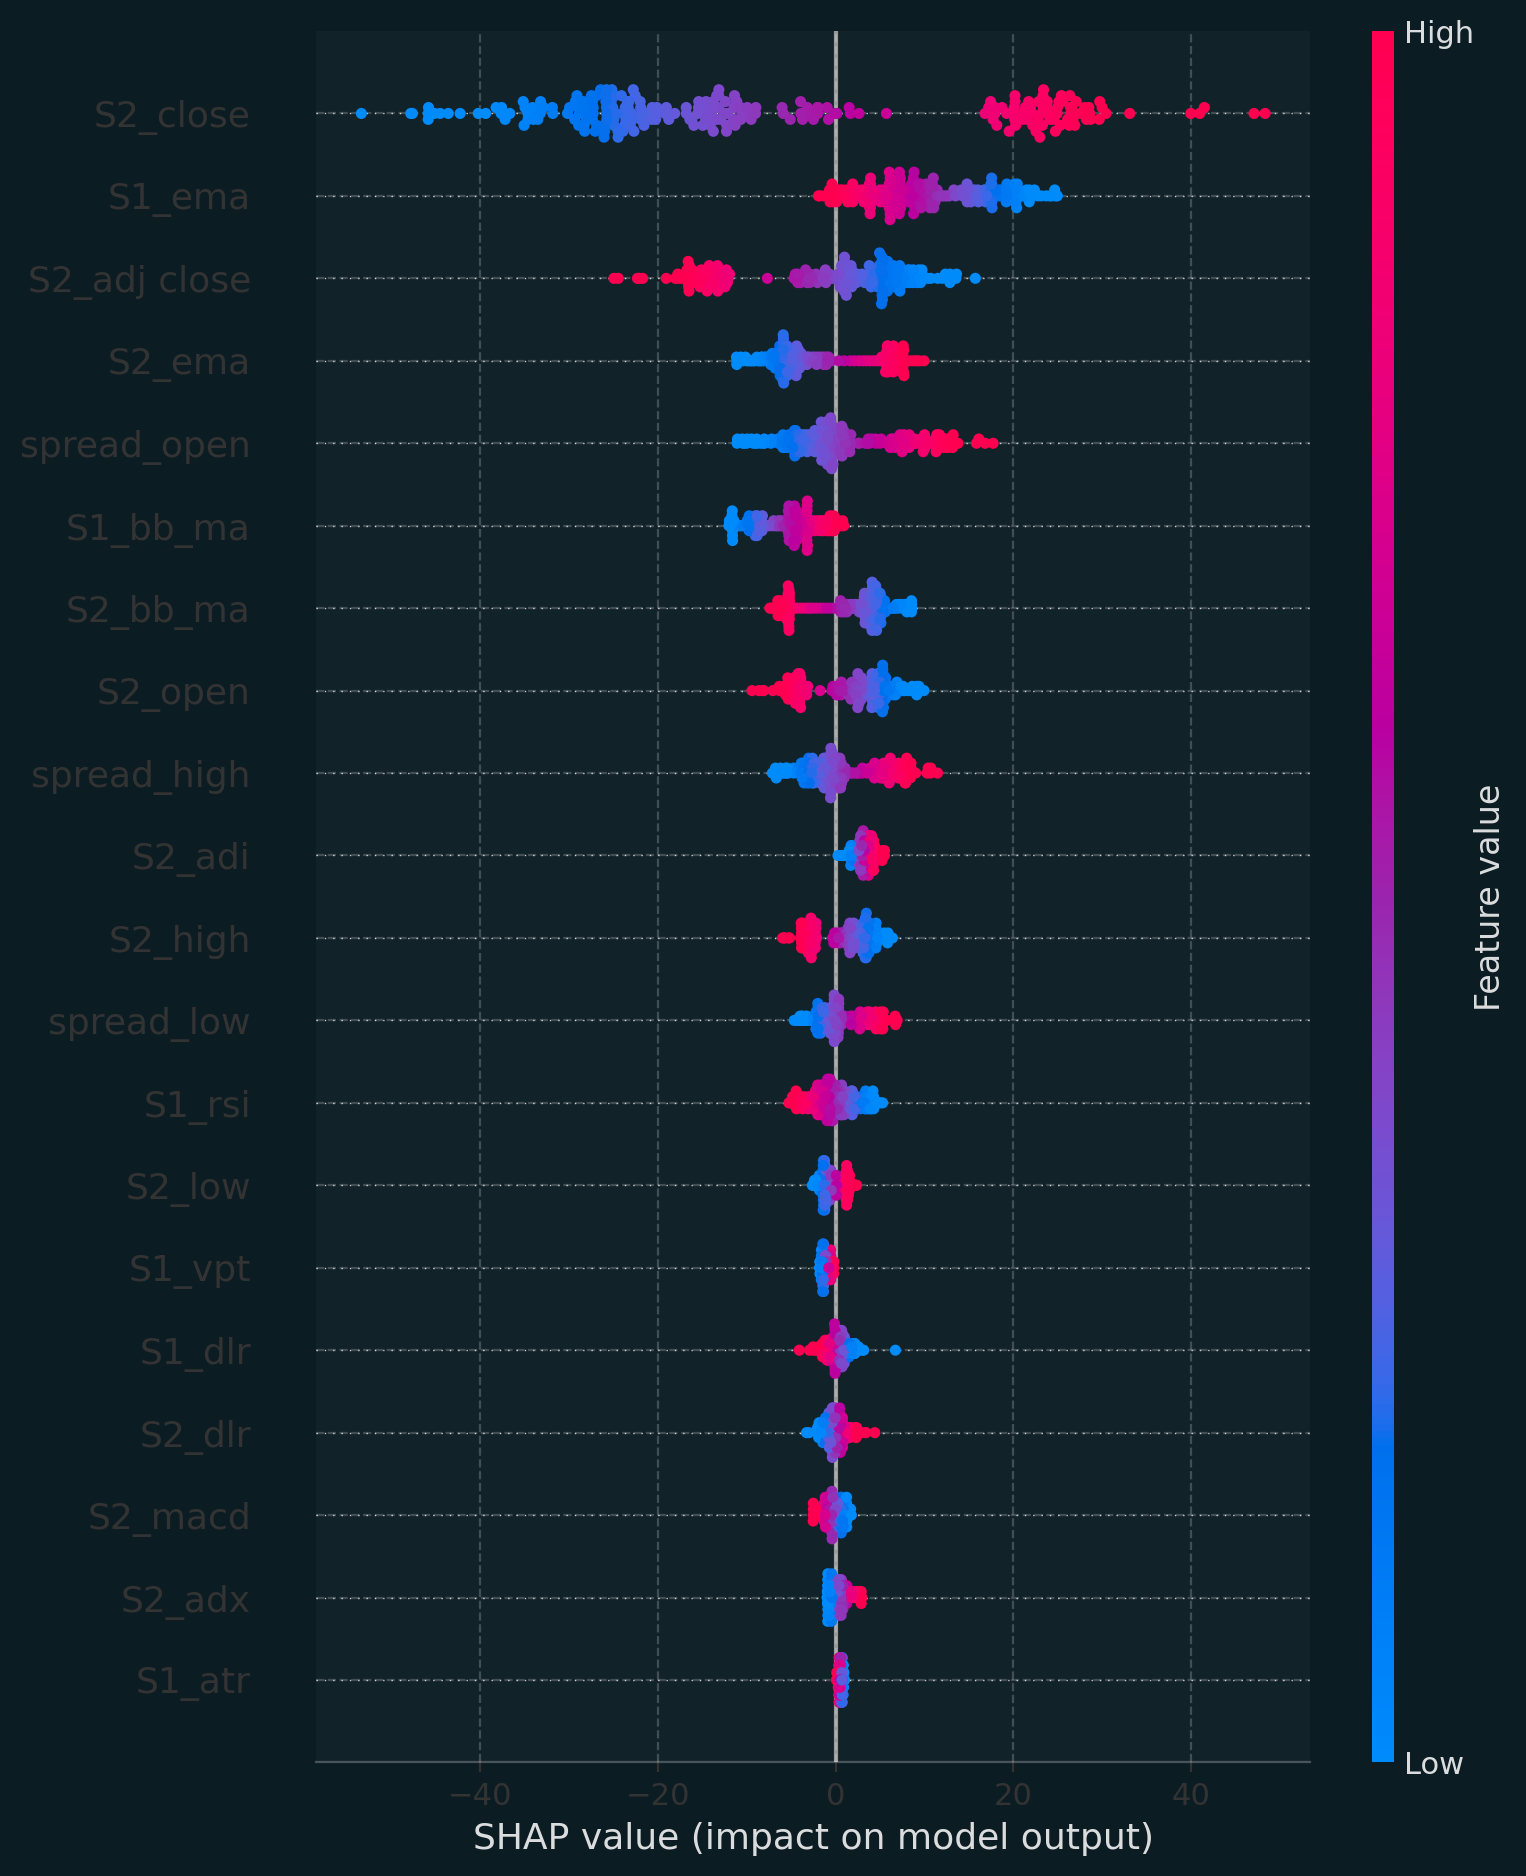

In [273]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error


data_tmp = pair_data.copy()

data_tmp = data_tmp.drop(columns=[
    'S1_open', 'S1_high', 'S1_low', 'S1_close', 'S1_adj close'])

LOOK_BACK = 1 # N-days to forward predict

train_data, val_data, test_data = create_dataset(
    data_tmp, 
    look_back=LOOK_BACK, 
    target_col="spread_close", 
    split_sizes=[0.7, 0.2, 0.1],
    drop_cols='spread_close'
    )

X_train, y_train = train_data.drop(columns=["target"]), train_data["target"]
X_val, y_val = val_data.drop(columns=["target"]), val_data["target"]
X_test, y_test = test_data.drop(columns=["target"]), test_data["target"]

# Combine val and test data since were not using Deep learning or hyper-param tuning 
X_test = pd.concat([X_val, X_test])
y_test = pd.concat([y_val, y_test])

model_reg = LinearRegression()
model_reg.fit(X_train, y_train)


y_pred = model_reg.predict(X_test)

print('\nMAPE: {:.2f}%'.format(mean_absolute_percentage_error(y_test, y_pred) * 100))

# extract feature importance
feature_importance = np.abs(model_reg.coef_)
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) 
names = X_train.columns

print("\nFeature Importance")
for i in sorted_idx:
    print(f"{names[i]:15s}: {feature_importance[i]:.10f}%")

# plot shap feature importance
import shap

shap.initjs()
explainer = shap.LinearExplainer(model_reg, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)


### Vanilla LR Using with spread as only feature


In [274]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression


# ---- Data Setup ----
LOOK_BACK = 1 # N-days to forward predict

train_data, val_data, test_data = create_dataset(
    pair_data, look_back=LOOK_BACK, 
    target_col="spread_close", 
    split_sizes=[0.7, 0.2, 0.1])

X_train, y_train = train_data.drop(columns=["target"]), train_data["target"]
X_val, y_val = val_data.drop(columns=["target"]), val_data["target"]
X_test, y_test = test_data.drop(columns=["target"]), test_data["target"]

# Combine val and test data since were not using Deep learning or hyper-param tuning 
X_test = pd.concat([X_val, X_test])
y_test = pd.concat([y_val, y_test])


train_data_reg = train_data.copy()
test_data_reg = test_data.copy()


target_var = "target"
feature_vars = train_data_reg.columns.drop(target_var)


X_train = train_data_reg[feature_vars]
y_train = train_data_reg[target_var]
X_test = test_data_reg[feature_vars]
y_test = test_data_reg[target_var]


model_reg = LinearRegression()
model_reg.fit(X_train, y_train)


forecast_steps = [1, 5, 55]
mape_values_reg = []

for steps in forecast_steps:

    X_test_steps = X_test.head(steps)
    y_test_steps = y_test.head(steps)
    y_pred_steps = model_reg.predict(X_test_steps)

    mape_reg = mean_absolute_percentage_error(y_test_steps, y_pred_steps)
    mape_values_reg.append(mape_reg)

    print(f"MAPE for {steps} step prediction (Regression): {mape_reg:.4f}")


for steps, mape_reg in zip(forecast_steps, mape_values_reg):
    print(f"MAPE for {steps} step prediction (Regression): {mape_reg:.4f}")

MAPE for 1 step prediction (Regression): 0.0814
MAPE for 5 step prediction (Regression): 0.1052
MAPE for 55 step prediction (Regression): 0.0785
MAPE for 1 step prediction (Regression): 0.0814
MAPE for 5 step prediction (Regression): 0.1052
MAPE for 55 step prediction (Regression): 0.0785


## ARIMA Model

In [276]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error

# ... (previous code remains the same)

# Train and evaluate ARIMA model
train_data_arima = train_data["target"]  
test_data_arima = test_data["target"]

# Specify the ARIMA model parameters (p, d, q)
p = 1
d = 0
q = 0

# Fit the ARIMA model
model = ARIMA(train_data_arima, order=(p, d, q))
model_fit = model.fit()

# Make forecasts for 1, 5, and 15 steps ahead
forecast_steps = [1, 5, 15]
mape_values = []

for steps in forecast_steps:
    # Make the forecast
    forecast = model_fit.forecast(steps=steps)

    # Calculate MAPE
    true_values = test_data_arima[:steps]
    predicted_values = forecast[:steps]
    mape = mean_absolute_percentage_error(true_values, predicted_values)
    mape_values.append(mape)

    print(f"MAPE for {steps} step forecast: {mape:.4f}")

# Print the MAPE values for each forecast step
for steps, mape in zip(forecast_steps, mape_values):
    print(f"MAPE for {steps} step forecast: {mape:.4f}")

MAPE for 1 step forecast: 0.1354
MAPE for 5 step forecast: 0.1037
MAPE for 15 step forecast: 0.2363
MAPE for 1 step forecast: 0.1354
MAPE for 5 step forecast: 0.1037
MAPE for 15 step forecast: 0.2363


### LSTM Model

In [44]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
keras = tf.keras
from keras.models import Sequential
from keras.layers import Dense, LSTM

# ... (previous code remains the same)

# Train and evaluate LSTM model
train_data_lstm = train_data.copy()
test_data_lstm = test_data.copy()

# Create the target variable and features for LSTM
target_var = 'spread'
feature_vars = train_data_lstm.columns.drop(target_var)

# Scale the data
scaler = MinMaxScaler()
train_data_lstm[feature_vars] = scaler.fit_transform(train_data_lstm[feature_vars])
test_data_lstm[feature_vars] = scaler.transform(test_data_lstm[feature_vars])

# Prepare the data for LSTM
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 10

X_train, y_train = create_dataset(train_data_lstm[feature_vars], train_data_lstm[target_var], time_steps)
X_test, y_test = create_dataset(test_data_lstm[feature_vars], test_data_lstm[target_var], time_steps)

# Create and fit the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(time_steps, len(feature_vars))))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

model_lstm.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)


# Make predictions for 1, 5, and 15 steps ahead
forecast_steps = [1, 5, 15]
mape_values_lstm = []

for steps in forecast_steps:
    # Make the prediction
    X_test_steps = X_test[:steps]
    y_test_steps = y_test[:steps]
    y_pred_steps = model_lstm.predict(X_test_steps)

    # Reshape the predictions to match the expected shape for inverse scaling
    y_pred_steps = y_pred_steps.reshape(-1, 1)

    # Inverse scale the predictions
    y_pred_steps = scaler.inverse_transform(y_pred_steps)

    # Calculate MAPE
    mape_lstm = mean_absolute_percentage_error(y_test_steps, y_pred_steps)
    mape_values_lstm.append(mape_lstm)

    print(f"MAPE for {steps} step prediction (LSTM): {mape_lstm:.4f}")


KeyboardInterrupt: 

In [ ]:

# Make predictions for 1, 5, and 15 steps ahead
forecast_steps = [1, 5, 15]
mape_values_lstm = []

for steps in forecast_steps:
    # Make the prediction
    X_test_steps = X_test[:steps]
    y_test_steps = y_test[:steps]
    y_pred_steps = model_lstm.predict(X_test_steps)

    # Inverse scale the predictions
    y_pred_steps = scaler.inverse_transform(y_pred_steps)

    # Calculate MAPE
    mape_lstm = mean_absolute_percentage_error(y_test_steps, y_pred_steps)
    mape_values_lstm.append(mape_lstm)

    print(f"MAPE for {steps} step prediction (LSTM): {mape_lstm:.4f}")

# Print the MAPE values for each prediction step
for steps, mape_lstm in zip(forecast_steps, mape_values_lstm):
    print(f"MAPE for {steps} step prediction (LSTM): {mape_lstm:.4f}")


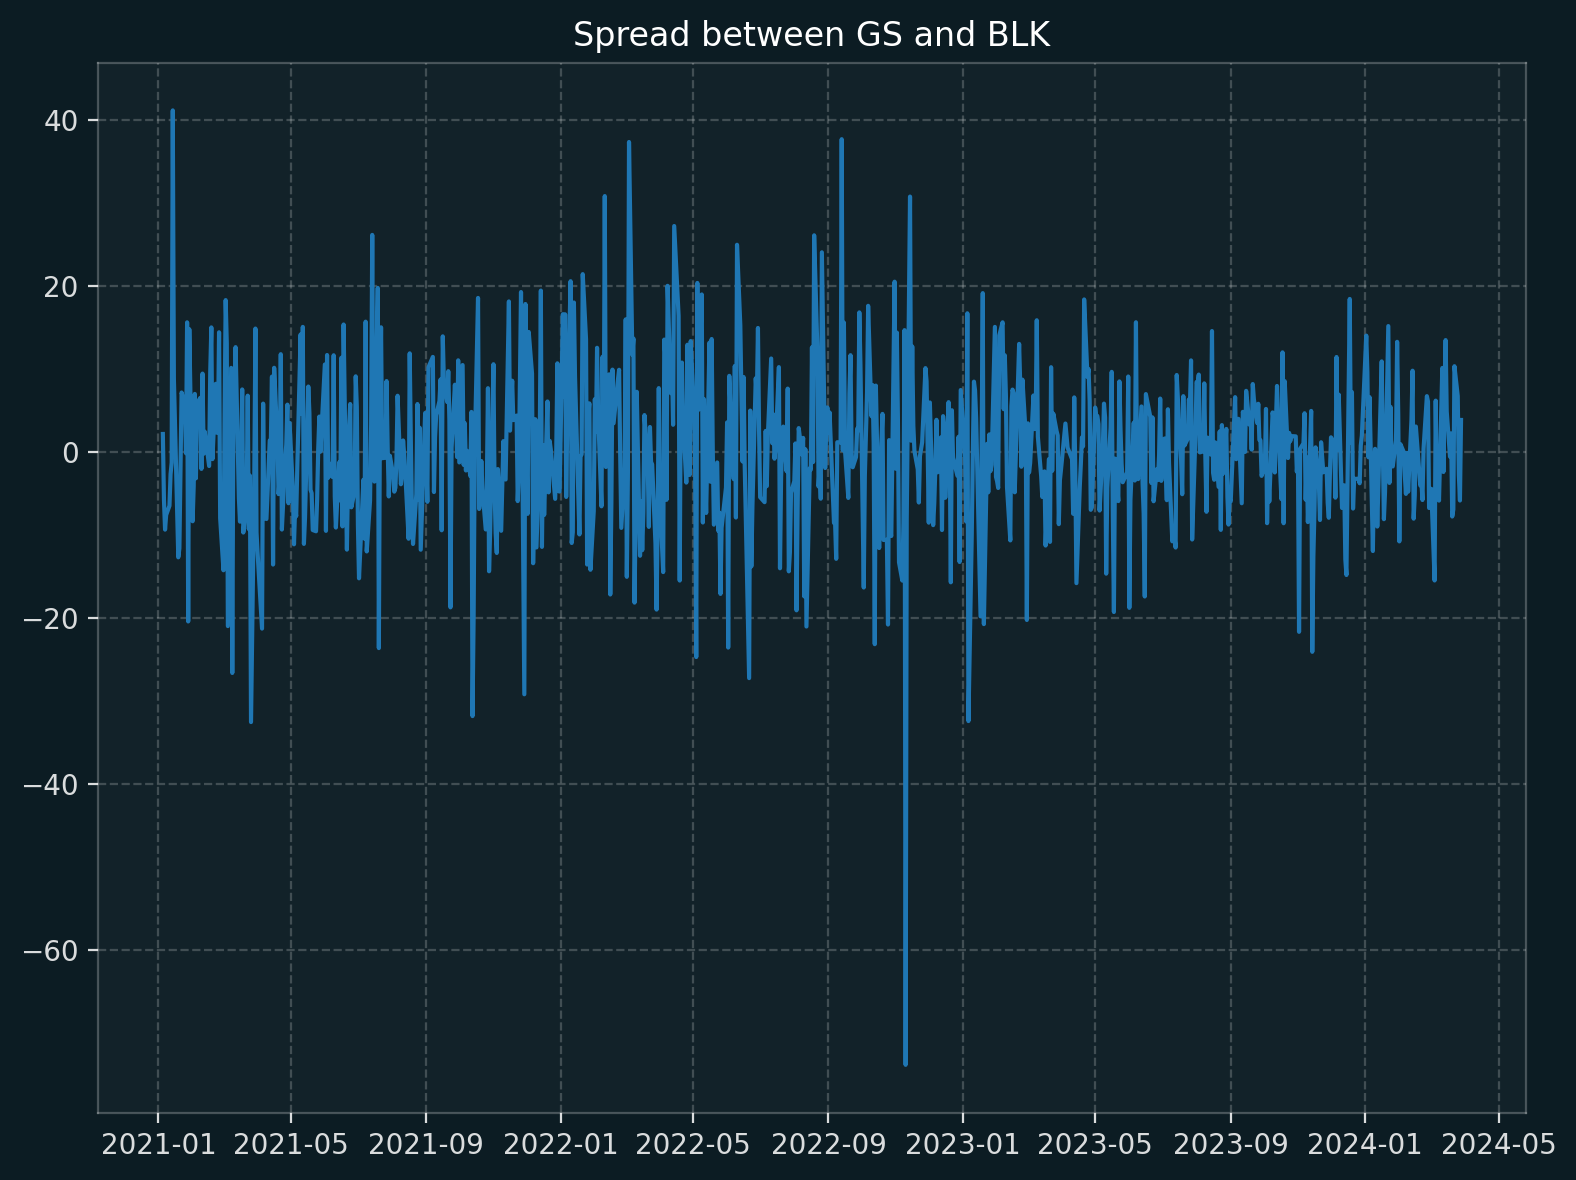

In [34]:
plt.figure(figsize=(8, 6))
plt.plot(spread)
plt.title(f"Spread between {ticker_0} and {ticker_1}")
plt.show()

In [277]:
from statsmodels.tsa.arima.model import ARIMA
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import mean_absolute_percentage_error

# Get the split date
split_date = pd.Timestamp.now() - DateOffset(months=6)

# Split the spread into a training set and a test set
train_spread = spread.loc[spread.index < split_date]
test_spread = spread.loc[spread.index >= split_date]

# Print the size of the training set and the test set
print("Training set size:", len(train_spread))
print("Test set size:", len(test_spread))

# Define the ARIMA model
model = ARIMA(train_spread, order=(5, 1, 0))

# Fit the model
model_fit = model.fit()

# Forecast the next 1, 5, and 15 time steps
forecast_1 = model_fit.forecast(steps=1)
forecast_5 = model_fit.forecast(steps=5)
forecast_15 = model_fit.forecast(steps=15)

# Print the forecasts
print("1 step forecast:", forecast_1)
print("5 steps forecast:", forecast_5)
print("15 steps forecast:", forecast_15)

# Evaluate the model on the test set
test_forecast = model_fit.forecast(steps=len(test_spread))
mape = mean_absolute_percentage_error(test_spread, test_forecast)

print(f"\nTest MAPE: {mape:.4f}")

Training set size: 695
Test set size: 119
1 step forecast: 695    47.261573
dtype: float64
5 steps forecast: 695    47.261573
696    47.110046
697    47.254411
698    47.375730
699    47.354834
Name: predicted_mean, dtype: float64
15 steps forecast: 695    47.261573
696    47.110046
697    47.254411
698    47.375730
699    47.354834
700    47.341109
701    47.348730
702    47.355802
703    47.354757
704    47.353717
705    47.354102
706    47.354522
707    47.354472
708    47.354400
709    47.354418
Name: predicted_mean, dtype: float64

Test MAPE: 0.3753
